In [1]:
"""ファブリック

点
"""

import numpy as np
from numpy import linalg as LA
from scipy import integrate
import sympy as sy
import matplotlib.pyplot as plt
import matplotlib.patches as patches


#import robot_sice_ex.sice_ex as sice_ex

def s(x_dot):
    if x_dot < 0:
        return 1
    else:
        return 0

def sigmoid(x, alpha):
    return 1 / (1 + sy.exp(-alpha * x))

(-1.0995000000000001, 1.089500000000002, -0.05, 1.05)

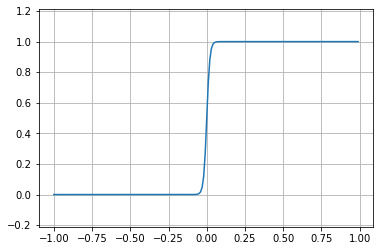

In [17]:
def sigmoid(x, alpha):
    return 1 / (1 + sy.exp(-alpha * (x)))
_x = np.arange(-1, 1, 0.01)
_y = [sigmoid(i, 100) for i in _x]
plt.plot(_x, _y)
plt.grid()
plt.axis('equal')

(-1.0995000000000001,
 1.089500000000002,
 -0.8375419799643795,
 0.8333101482251417)

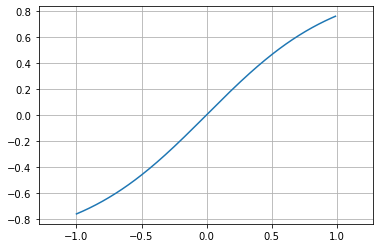

In [18]:

_x = np.arange(-1, 1, 0.01)
_y = [np.tanh(i) for i in _x]
plt.plot(_x, _y)
plt.grid()
plt.axis('equal')

In [47]:
x = sy.MatrixSymbol('x', 2, 1)
x_dot = sy.MatrixSymbol('x_dot', 2, 1)
x_norm = sy.sqrt(x[0,0]**2 + x[1,0]**2)
m_u, m_l, alpha_m, k, alpha_psi = sy.symbols('m_U, m_l, alpha_m, k, alpha_psi')

G = (m_u - m_l) * sy.exp(-(alpha_m * x_norm)**2) * sy.eye(2) + m_u * sy.eye(2)
psi_1 = k * (x_norm + 1/alpha_psi * sy.ln(1 + sy.exp(-2 * alpha_psi * x_norm)))

L = (x_dot.T * G * x_dot)[0,0]
M_ee = sy.Matrix([[sy.diff(L, x_dot[0,0]), sy.diff(L, x_dot[1,0])]]).T.jacobian(x_dot)

xi_ee = sy.Matrix([[sy.diff(L, x_dot[0,0]), sy.diff(L, x_dot[1,0])]]).T.jacobian(x) * x_dot \
    - sy.Matrix([[sy.diff(L, x[0,0])], [sy.diff(L, x[1,0])],])

#M_ee = G
pi_ee = -sy.Matrix([
    [sy.diff(psi_1, x[0,0])],
    [sy.diff(psi_1, x[1,0])],
])

func_M_ee = sy.lambdify((x, x_dot, m_u, m_l, alpha_m, k, alpha_psi), M_ee, "numpy")
func_xi_ee = sy.lambdify((x, x_dot, m_u, m_l, alpha_m, k, alpha_psi), xi_ee, "numpy")
func_pi_ee = sy.lambdify((x, x_dot, m_u, m_l, alpha_m, k, alpha_psi), pi_ee, "numpy")


The solver successfully reached the end of the integration interval.


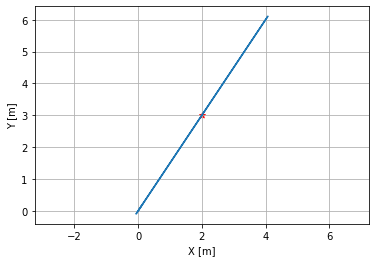

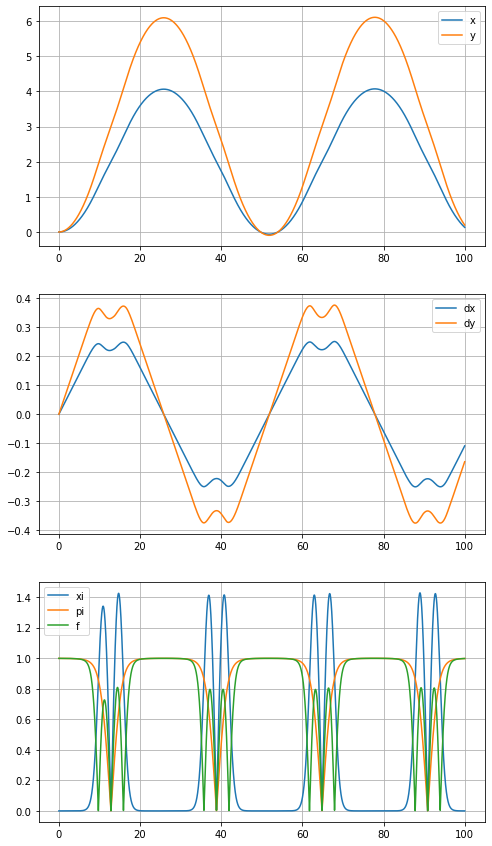

In [56]:
xd = np.array([[2, 3]]).T
m_u = 10
m_l = 1
alpha_m = 1
k = 1
alpha_psi = 1

def dX(t, X):
    x = X[:2].reshape(-1, 1)
    x_dot = X[2:].reshape(-1, 1)
    
    M = func_M_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    xi = func_xi_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    pi = func_pi_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    damp = 0*x_dot
    f = pi - xi - damp
    a = LA.pinv(M) @ f
    return np.ravel(np.concatenate([x_dot, a]))

X0 = np.array([0, 0, 0, 0.0])
time_interval = 0.01
time_span = 100
tspan = (0, time_span)
teval = np.arange(0, time_span, time_interval)
sol = integrate.solve_ivp(fun=dX, t_span=tspan, y0=X0, t_eval=teval)
print(sol.message)

xi_, pi_, f_ = [], [], []
for i in range(len(sol.t)):
    x = np.array([[sol.y[0][i], sol.y[1][i]]]).T
    x_dot = np.array([[sol.y[2][i], sol.y[3][i]]]).T
    M = func_M_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    xi = func_xi_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    pi = func_pi_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    damp = 0*x_dot
    f = pi - xi - damp
    
    xi_.append(LA.norm(xi))
    pi_.append(LA.norm(pi))
    f_.append(LA.norm(f))


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[1])
ax.scatter([xd[0,0]], [xd[1,0]], marker="*", color = "r")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.grid()
ax.axis('equal')
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 15))
axes[0].plot(sol.t, sol.y[0], label="x")
axes[0].plot(sol.t, sol.y[1], label="y")
axes[1].plot(sol.t, sol.y[2], label="dx")
axes[1].plot(sol.t, sol.y[3], label="dy")
axes[2].plot(sol.t, xi_, label="xi")
axes[2].plot(sol.t, pi_, label="pi")
axes[2].plot(sol.t, f_, label="f")
for ax in axes.ravel():
    ax.legend()
    ax.grid()


----
障害物

In [51]:
# obs avoidance
r, k_b, alpha_b, alpha_sig = sy.symbols('r, k_b, alpha_b, alpha_sig')
x = sy.Symbol('x')
x_dot = sy.Symbol('x_dot')

psi_1b = alpha_b / (2 * x**8)
grad_psi_1b = sy.diff(psi_1b, x)

G = sigmoid(x_dot, alpha_sig) * k_b / x**2
L = x_dot * G * x_dot

M = sy.diff(L, (x_dot, 2))
xi = sy.diff(sy.diff(L, x_dot), x) - sy.diff(L, x)



func_M_obs = sy.lambdify((x, x_dot, k_b, alpha_b, alpha_sig), M, "numpy")
func_xi_obs = sy.lambdify((x, x_dot, k_b, alpha_b, alpha_sig), xi, "numpy")
func_pi_obs = sy.lambdify((x, x_dot, k_b, alpha_b, alpha_sig), grad_psi_1b, "numpy")



q = sy.MatrixSymbol('q', 2, 1)
q_o = sy.MatrixSymbol('q_o', 2, 1)
q_dot = sy.MatrixSymbol('q_dot', 2, 1)
q_ = q - q_o
phi = sy.sqrt(q_[0,0]**2 + q_[1,0]**2) / r - 1
s = phi
J = sy.Matrix([[sy.diff(phi, q[0,0]), sy.diff(phi, q[1,0])]])
#s_dot = (1/r * 1/sy.sqrt(q_[0,0]**2 + q_[1,0]**2) * q_.T * q_dot)[0,0]
s_dot = (J * q_dot)[0,0]

func_s = sy.lambdify((q, q_dot, q_o, r), s, "numpy")
func_s_dot = sy.lambdify((q, q_dot, q_o, r), s_dot, "numpy")
func_J = sy.lambdify((q, q_dot, q_o, r), J, "numpy")


In [50]:
M

k_b*(-alpha_sig**2*x_dot**2*(1 - 2*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot)))*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot)) + 4*alpha_sig*x_dot*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot)) + 2)/(x*(1 + exp(-alpha_sig*x_dot)))

<lambdifygenerated-31>:2: RuntimeWarning: overflow encountered in exp
  return k_b*(-alpha_sig**2*x_dot**2*(1 - 2*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot)))*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot)) + 4*alpha_sig*x_dot*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot)) + 2)/(x**2*(1 + exp(-alpha_sig*x_dot)))
<lambdifygenerated-31>:2: RuntimeWarning: invalid value encountered in double_scalars
  return k_b*(-alpha_sig**2*x_dot**2*(1 - 2*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot)))*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot)) + 4*alpha_sig*x_dot*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot)) + 2)/(x**2*(1 + exp(-alpha_sig*x_dot)))
<lambdifygenerated-32>:2: RuntimeWarning: overflow encountered in exp
  return -2*alpha_sig*k_b*x_dot**2*exp(-alpha_sig*x_dot)/(x**3*(1 + exp(-alpha_sig*x_dot))**2) + 2*k_b*x_dot**2/(x**3*(1 + exp(-alpha_sig*x_dot))) - 4*k_b*x_dot/(x**3*(1 + exp(-alpha_sig*x_dot)))
<lambdifygenerated-32>:2: RuntimeWarning: invalid value encountered 

The solver successfully reached the end of the integration interval.


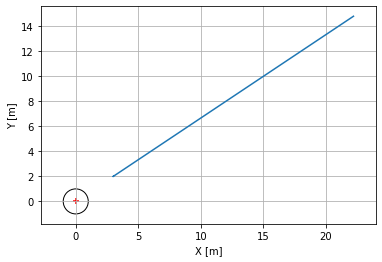

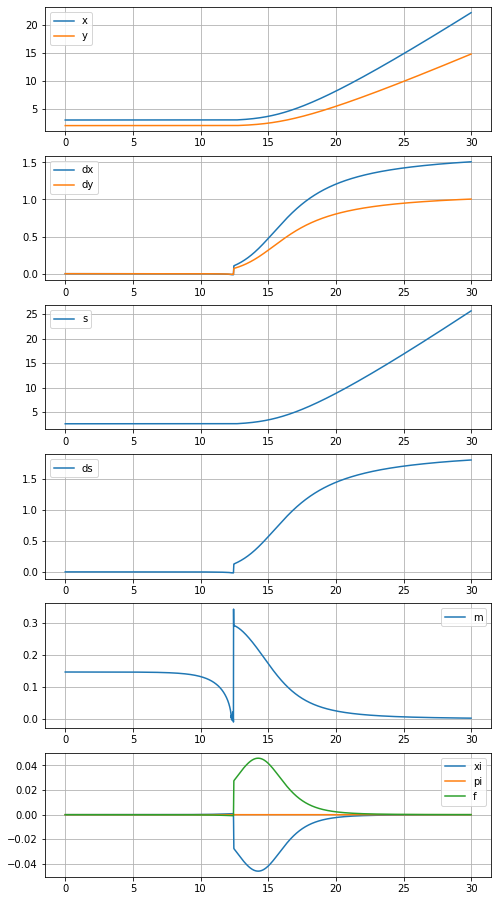

In [52]:
xo = np.array([[0, 0]]).T
r = 1
k_b = 1
alpha_b = 0.0001
alpha_sig = 50

def dX(t, X):
    x = X[:2].reshape(-1, 1)
    x_dot = X[2:].reshape(-1, 1)
    
    s = func_s(x, x_dot, xo, r)
    s_dot = func_s_dot(x, x_dot, xo, r)
    J = func_J(x, x_dot, xo, r)
    
    m = func_M_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    xi = func_xi_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    pi = func_pi_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    #pi = 0
    #damp = np.zeros((2,1))
    damp = 0. * s_dot
    #print("s_dot = ", s_dot)
    f = pi - xi - damp
    
    pull_M = m * J.T @ J
    pull_f = J.T * f
    
    a = LA.pinv(pull_M) @ pull_f

    # print("M = ", np.ravel(M))
    # print("xi = ", xi.T)
    # print("pi = ", pi.T)
    return np.ravel(np.concatenate([x_dot, a]))


X0 = np.array([3, 2, -0., 0.0])
time_interval = 0.01
time_span = 30
tspan = (0, time_span)
teval = np.arange(0, time_span, time_interval)
sol = integrate.solve_ivp(fun=dX, t_span=tspan, y0=X0, t_eval=teval)
print(sol.message)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[1])
ax.scatter([xo[0,0]], [xo[1,0]], marker="+", color = "r")
c = patches.Circle(xy=(xo[0,0], xo[1,0]), radius=r, ec='k', fill=False)
ax.add_patch(c)
ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]"); ax.grid(); ax.axis('equal')


s_, s_dot_, m_, xi_, pi_, f_ = [], [], [], [], [], []
for i in range(len(sol.t)):
    x = np.array([[sol.y[0][i], sol.y[1][i]]]).T
    x_dot = np.array([[sol.y[2][i], sol.y[3][i]]]).T
    s = func_s(x, x_dot, xo, r)
    s_dot = func_s_dot(x, x_dot, xo, r)
    J = func_J(x, x_dot, xo, r)
    m = func_M_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    xi = func_xi_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    pi = func_pi_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    #pi = 0
    #damp = np.zeros((2,1))
    damp = 0. * s_dot
    #print("s_dot = ", s_dot)
    f = pi - xi - damp
    
    pull_M = m * J.T @ J
    pull_f = J.T * f
    
    a = LA.pinv(pull_M) @ pull_f
    
    s_.append(s)
    s_dot_.append(s_dot)
    m_.append(m)
    xi_.append(xi)
    pi_.append(pi)
    f_.append(f)


fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(8, 16))
axes[0].plot(sol.t, sol.y[0], label="x")
axes[0].plot(sol.t, sol.y[1], label="y")
axes[1].plot(sol.t, sol.y[2], label="dx")
axes[1].plot(sol.t, sol.y[3], label="dy")
axes[2].plot(sol.t, s_, label="s")
axes[3].plot(sol.t, s_dot_, label="ds")
axes[4].plot(sol.t, m_, label="m")
axes[5].plot(sol.t, xi_, label="xi")
axes[5].plot(sol.t, pi_, label="pi")
axes[5].plot(sol.t, f_, label="f")


for ax in axes.ravel():
    ax.legend()
    ax.grid()
plt.show()

: 